In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
def prepare_mnist(plot=False, c1=3, c2=6):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize images to [0, 1]
    x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

    print('Number of original training examples:', len(x_train))
    print('Number of original test examples:', len(x_test))
    
    # Filter labels c1 and c2
    x_train, y_train = filter_labels(x_train, y_train, c1, c2)
    x_test, y_test = filter_labels(x_test, y_test, c1, c2)

    print('Number of filtered training examples:', len(x_train))
    print('Number of filtered test examples:', len(x_test))
    
    if plot:
        plt.imshow(x_train[0, :, :, 0])
        plt.colorbar()
    
    return x_train, y_train, x_test, y_test

In [3]:
def prepare_fashion_mnist(plot=False, c1=0, c2=3):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    
    # Normalize images to [0, 1]
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    print("Number of original training examples:", len(x_train))
    print("Number of original test examples:", len(x_test))
    
    # Filter labels c1 and c2
    x_train, y_train = filter_labels(x_train, y_train, 0, 3)
    x_test, y_test = filter_labels(x_test, y_test, 0, 3)
    
    print("Number of filtered training examples:", len(x_train))
    print("Number of filtered training examples:", len(x_test))
    
    if plot:
        plt.imshow(x_train[0, :, :])
        plt.colorbar()
        
    return x_train, y_train, x_test, y_test

In [4]:
def prepare_olivetti(plot=False, c1=1, c2=3):
    # Olivetti images already come normalized
    import os
    path = '../datasets/olivetti'
    data = np.load(os.path.join(path, 'olivetti_faces.npy'))
    labels = np.load(os.path.join(path, 'olivetti_faces_target.npy'))
        
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)
    
    # Normalize images to [0, 1]
    x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
    
    print('Number of original training examples:', len(x_train))
    print('Number of original test examples:', len(x_test))
    
    # Filter labels c1 and c2
    x_train, y_train = filter_labels(x_train, y_train, c1, c2)
    x_test, y_test = filter_labels(x_test, y_test, c1, c2)

    print('Number of filtered training examples:', len(x_train))
    print('Number of filtered test examples:', len(x_test))
    
    # Transform labels into 0 or 1 classes
    #y_train = y_train.astype(int)
    #y_test = y_test.astype(int)
    
    print(x_train.shape)
    if plot:
        # Show the first image
        plt.imshow(x_train[0, :, :, 0])
        plt.colorbar()
        
    return x_train, y_train, x_test, y_test

In [5]:
def filter_labels(x, y, c1, c2):
    keep = (y == c1) | (y == c2)
    x, y = x[keep], y[keep]
    y = y == c1
    return x, y

In [6]:
def truncate_pca(x_train, x_test, n_components=10):
    """Perform PCA on image dataset keeping the top `n_components` components."""
    n_points_train = tf.gather(tf.shape(x_train), 0)
    n_points_test = tf.gather(tf.shape(x_test), 0)

    # Flatten to 1D
    x_train = tf.reshape(x_train, [n_points_train, -1])
    x_test = tf.reshape(x_test, [n_points_test, -1])

    # Normalize.
    feature_mean = tf.reduce_mean(x_train, axis=0)
    x_train_normalized = x_train - feature_mean
    x_test_normalized = x_test - feature_mean

    # Truncate.
    e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
    
    return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

In [7]:
def prepare_data_pca(x_train, y_train, x_test, y_test, n_components=10):
    # Resize with PCA
    x_train, x_test = truncate_pca(x_train, x_test, n_components=n_components)
    print(x_train.shape)
    
    train_split = 1000
    test_split = 200
    
    # Filter number of samples
    x_train, x_test = x_train[:train_split], x_test[:test_split]
    y_train, y_test = y_train[:train_split], y_test[:test_split]
    
    print("Prepared number of training examples:", len(x_train))
    print("Prepared number of test examples:", len(x_test))

    THRESHOLD = 0.5

    x_train_bin = np.array(x_train > THRESHOLD, dtype=np.float32)
    x_test_bin = np.array(x_test > THRESHOLD, dtype=np.float32)
    
    return x_train_bin, x_test_bin, x_train, y_train, x_test, y_test

In [8]:
def prepare_data(x_train, y_train, x_test, y_test, plot=False, contradicting=False):
    x_train = tf.image.resize(x_train, (4,4)).numpy()
    x_test = tf.image.resize(x_test, (4,4)).numpy()
    print(x_train.shape)
    
    if plot:
        plt.imshow(x_train[0,:,:,0], vmin=0, vmax=1)
        plt.colorbar()
        
    if contradicting:
        x_train, y_train = remove_contradicting(x_train, y_train)
        
    THRESHOLD = 0.5

    x_train_bin = np.array(x_train > THRESHOLD, dtype=np.float32)
    x_test_bin = np.array(x_test > THRESHOLD, dtype=np.float32)
    
    return x_train_bin, x_test_bin, x_train, y_train, x_test, y_test

#### Remove contrary examples according to Farhi et al.

In [9]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_c1 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_c2 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique c1: ", num_uniq_c1)
    print("Number of unique c2: ", num_uniq_c2)
    print("Number of unique contradicting labels: ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

#### Prepares splits from several datasets. Only the cell of the desirable dataset should be run.

> **NOTE**: Keep in mind that this particular circuit has been proven to be effective when solving for MNIST numbers. Expect low accuracy on the other datasets. These samples were tested simply for the scope of the investigation.

In [ ]:
# Olivetti
x_train_olivetti, y_train_olivetti, x_test_olivetti, y_test_olivetti = prepare_olivetti(plot=True)
x_train_bin, x_test_bin, x_train, y_train, x_test, y_test = prepare_data(x_train_olivetti, y_train_olivetti, x_test_olivetti, y_test_olivetti, plot=True)

Number of original training examples: 60000
Number of original test examples: 10000
Number of filtered training examples: 12049
Number of filtered test examples: 1968
(12049, 4, 4, 1)
Number of unique images: 10387
Number of unique c1:  4912
Number of unique c2:  5426
Number of unique contradicting labels:  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


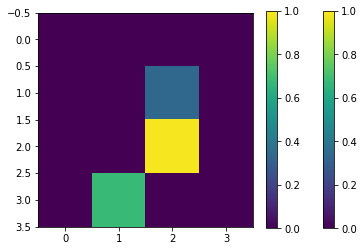

In [10]:
# Mnist
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist = prepare_mnist(plot=True)
x_train_bin, x_test_bin, x_train, y_train, x_test, y_test = prepare_data(x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist, plot=True, contradicting=True)

In [ ]:
# Fashion Mnist
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist = prepare_fashion_mnist(plot=True)
x_train_bin, x_test_bin, x_train, y_train, x_test, y_test = prepare_data_pca(x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)

In [11]:
def convert_to_circuit_flat(flat_image):
    """Encode pca flattened image into quantum datapoint"""
    qubits = cirq.GridQubit.rect(1, len(flat_image))
    circuit = cirq.Circuit()
    for i, value in enumerate(flat_image):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [12]:
def convert_to_circuit_2d(image):
    """Encode truncated classical image into quantum datapoint"""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [13]:
def circ(x_train_bin, x_test_bin):
    if len(x_train_bin.shape) <= 2:
        x_train_cir = [convert_to_circuit_flat(x) for x in x_train_bin]
        x_test_cir = [convert_to_circuit_flat(x) for x in x_test_bin]
        bin_img = x_train_bin[0,0]
    else:
        x_train_cir = [convert_to_circuit_2d(x) for x in x_train_bin]
        x_test_cir = [convert_to_circuit_2d(x) for x in x_test_bin]
        bin_img = x_train_bin[0,:,:,0]

    indices = np.array(np.where(bin_img)).T

    x_train_tfcirc = tfq.convert_to_tensor(x_train_cir)
    x_test_tfcirc = tfq.convert_to_tensor(x_test_cir)

    return x_train_cir, x_test_cir, x_train_tfcirc, x_test_tfcirc

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


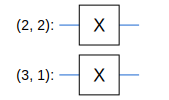

In [14]:
x_train_cir, x_test_cir, x_train_tfcirc, x_test_tfcirc = circ(x_train_bin, x_test_bin)
SVGCircuit(x_train_cir[0])

#### Model

In [15]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
        
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

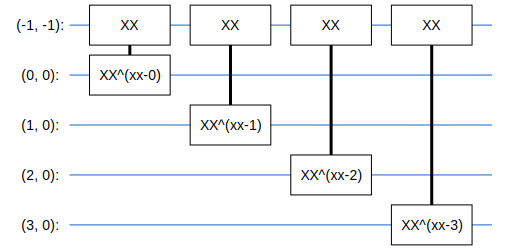

In [16]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4, 1),
                                readout = cirq.GridQubit(-1, -1))
circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate=cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [17]:
def create_quantum_model():
    """Create QNN model circuit and readout"""
    data_qubits = cirq.GridQubit.rect(4, 4) # 4x4 grid
    readout = cirq.GridQubit(-1, -1) # one qubit at (-1, -1)
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits=data_qubits,
        readout=readout)
    
    # Add layers
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    
    # Readout qubit
    circuit.append(cirq.H(readout))
    
    return circuit, cirq.Z(readout)

In [18]:
model_circuit, model_readout = create_quantum_model()

In [19]:
model = tf.keras.Sequential([
    # The input is the data-circuit
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # PQC layer returns the expected value of the readout gate, range [-1, 1]
    tfq.layers.PQC(model_circuit, model_readout),
])

In [20]:
y_train_hinge = 2.0 * y_train - 1.0
y_test_hinge = 2.0 * y_test - 1.0

In [21]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    
    return tf.reduce_mean(result)

In [22]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
def train(epochs, batch_size, x_train_tfcirc, y_train_hinge):
    num_examples = len(x_train_tfcirc)
    
    x_train_tfcirc_sub = x_train_tfcirc[:num_examples]
    y_train_hinge_sub = y_train_hinge[:num_examples]
    
    qnn_history = model.fit(
        x_train_tfcirc_sub, y_train_hinge_sub,
        batch_size=32,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test_tfcirc, y_test_hinge))
    
    qnn_results = model.evaluate(x_test_tfcirc, y_test)
    return qnn_results

In [25]:
qnn_results = train(3, 32, x_train_tfcirc, y_train_hinge)

Epoch 1/3
324/324 [==============================] - 153s 473ms/step - loss: 0.9080 - hinge_accuracy: 0.6033 - val_loss: 0.4712 - val_hinge_accuracy: 0.7747
Epoch 2/3
324/324 [==============================] - 153s 472ms/step - loss: 0.4314 - hinge_accuracy: 0.8232 - val_loss: 0.3853 - val_hinge_accuracy: 0.8936
Epoch 3/3
62/62 [==============================] - 4s 56ms/step - loss: 0.3578 - hinge_accuracy: 0.8997


In [28]:
def test_display_sample(n_samples, X_orig, X, y, model, batch_size=32):
    from PIL import Image
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 3))

    while count < n_samples:
        predictions = model.predict(X[:batch_size])

        pred = predictions < 0
        elem = '2' if pred[count] else '1'
        confidence = predictions[:, 0]

        axes[count].imshow(X_orig[count], cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(elem))

        count += 1

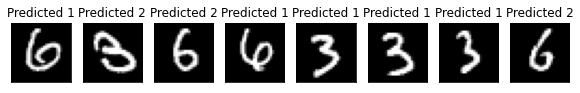

In [29]:
test_display_sample(8, x_test_mnist, x_test_tfcirc, y_test_mnist, model)